In [8]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
import scipy.sparse as sps
%matplotlib inline  
%load_ext Cython

from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender


from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [2]:
# data_train_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv"
# data_target_user_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv"
data_train_path="data_train.csv"
data_target_user_path="data_target_users_test.csv"
data_train = pd.read_csv(data_train_path)
data_target = pd.read_csv(data_target_user_path)

In [3]:
URM_all =  data_train.pivot(index='row', columns='col', values='data').fillna(0)
item_map = {i : item for i, item in enumerate(URM_all.columns)}
user_map = {i : user for i, user in enumerate(data_target["user_id"])}
item_map_inv = {item : i for i, item in item_map.items()}
user_map_inv = {user : i for i, user in user_map.items()}
missing_index = [x for x in range(1,13025) if x not in URM_all.index.tolist()]
add_urm = pd.DataFrame(index = missing_index, columns = URM_all.columns).fillna(0)
URM_all = pd.concat([URM_all, add_urm]).sort_index()
del add_urm
del missing_index
#data_target["user_id"] = data_target["user_id"]
URM_all = URM_all.to_numpy()
urm_sparse = sps.csr_matrix(URM_all)
urm_sparse

<13024x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [6]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(urm_sparse, train_percentage = 0.80)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2531 (19.4%) Users that have less than 1 test interactions


In [37]:
item_knn_recommender = ItemKNNCFRecommender(URM_train)
user_knn_recommender = UserKNNCFRecommender(URM_train)

item_knn_recommender.fit(shrink=3, topK=23)
user_knn_recommender.fit(shrink=0, topK=483)



ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 132 ( 0.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 132 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2214.96 column/sec. Elapsed time 10.03 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1199.49 column/sec. Elapsed time 10.86 sec


In [38]:
score_item_knn = item_knn_recommender._compute_item_score(user_id_array=0)
score_user_knn = user_knn_recommender._compute_item_score(user_id_array=0)

score_item_knn, score_user_knn

(array([[0.32039568, 0.17823893, 0.48859325, ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([[1.0956885 , 0.84090763, 1.5057833 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32))

In [16]:
from Recommenders.BaseRecommender import BaseRecommender

class ScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ScoresHybridRecommender"

    def __init__(self, URM_train, recommender_1, recommender_2):
        super(ScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
    def fit(self, alpha = 0.5):
        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        # In a simple extension this could be a loop over a list of pretrained recommender objects
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights

In [41]:
alpha_df = pd.DataFrame(columns = ["alpha", "MAP"])
for i, a in enumerate(np.arange(0.875,0.976,0.01)):
    scoreshybridrecommender = ScoresHybridRecommender(URM_train, item_knn_recommender, user_knn_recommender)
    scoreshybridrecommender.fit(alpha = a)

    result_df, _ = evaluator_test.evaluateRecommender(scoreshybridrecommender)
    alpha_df.loc[i] = [a, result_df["MAP"]]

ScoresHybridRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ScoresHybridRecommender: URM Detected 132 ( 0.6%) items with no interactions.
EvaluatorHoldout: Processed 10493 (100.0%) in 11.81 sec. Users per second: 888
ScoresHybridRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ScoresHybridRecommender: URM Detected 132 ( 0.6%) items with no interactions.
EvaluatorHoldout: Processed 10493 (100.0%) in 11.43 sec. Users per second: 918
ScoresHybridRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ScoresHybridRecommender: URM Detected 132 ( 0.6%) items with no interactions.
EvaluatorHoldout: Processed 10493 (100.0%) in 11.39 sec. Users per second: 921
ScoresHybridRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ScoresHybridRecommender: URM Detected 132 ( 0.6%) items with no interactions.
EvaluatorHoldout: Processed 10493 (100.0%) in 11.37 sec. Users per second: 923
ScoresHybridRecommender: URM Detected 609 ( 4.7%) users with

C:\Users\feder\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
C:\Users\feder\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


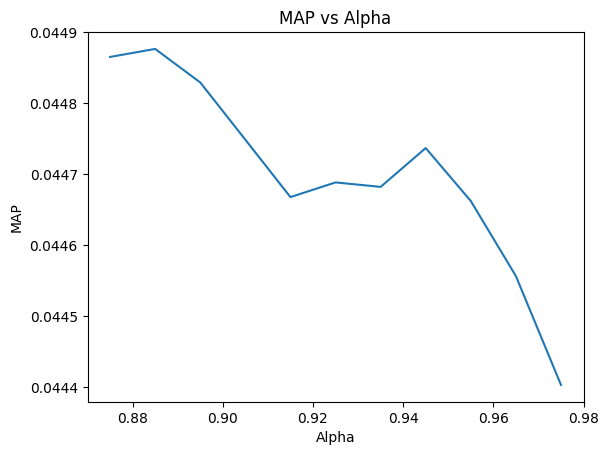

In [42]:
pyplot.plot(alpha_df["alpha"], alpha_df["MAP"])
pyplot.xlabel("Alpha")
pyplot.ylabel("MAP")
pyplot.title("MAP vs Alpha")
pyplot.show()


In [43]:
best_alpha_value = alpha_df.loc[alpha_df["MAP"].astype(float).idxmax()]
best_alpha_value

C:\Users\feder\AppData\Local\Temp\ipykernel_23512\619541529.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  best_alpha_value = alpha_df.loc[alpha_df["MAP"].astype(float).idxmax()]


alpha                                             0.885
MAP      cutoff
10    0.044877
Name: MAP, dtype: object
Name: 1, dtype: object

In [44]:
import time
scoreshybridrecommender = ScoresHybridRecommender(URM_train, item_knn_recommender, user_knn_recommender)
scoreshybridrecommender.fit(alpha = a)
n_users_to_test = len(data_target["user_id"])
suggestions = pd.DataFrame(columns = ["user_id", "item_list"])
start_time = time.time()

for user_id in (data_target["user_id"]-1):
    suggestion = scoreshybridrecommender.recommend(user_id, cutoff=10)
    suggestions.loc[len(suggestions)] = [user_id+1, " ".join([str(item_map[x]) for x in suggestion])] #" ".join([str(x) for x in np.flip(np.sort(suggestion_values))[0][:10]]
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

ScoresHybridRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ScoresHybridRecommender: URM Detected 132 ( 0.6%) items with no interactions.


Reasonable implementation speed is 595.03 usr/sec


In [45]:
suggestions.to_csv("outputs/hybrid.csv", index=False)